In [2]:
%load_ext autoreload
%autoreload 2

import xarray as xa
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
from pathlib import Path
import geopandas as gpd
from tqdm import tqdm
import numpy as np

from coralshift.dataloading import config
from coralshift import functions_creche
from coralshift.processing import spatial_data
from coralshift.plotting import spatial_plots

ERROR 1: PROJ: proj_create_from_database: Open of /home/jovyan/lustre_scratch/conda-envs/coralshift/share/proj failed


In [2]:
# resolution_lat, resolution_lon = 0.01, 0.01
# resolution = 0.1
lats = [-34, 0]
lons = [130, 170]

### Investigation of depth-coral relationship

In [3]:
# gebco bathymetry fp
gebco_fp = (
    Path(config.bathymetry_folder) / "gebco/gebco_2023_n0.0_s-40.0_w130.0_e170.0.nc"
)
gebco_xa = spatial_data.process_xa_d(xa.open_dataset(gebco_fp))

# unep_wcmc shp fp
unep_fp = Path(config.gt_folder) / "unep_wcmc/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp"
unep_gdf = gpd.read_file(unep_fp)

In [16]:
# testing appearance of resample_xa_d
lat_range = [gebco_xa.latitude.values[0], gebco_xa.longitude.values[-1]]    
lon_range = [gebco_xa.longitude.values[0], gebco_xa.longitude.values[-1]]
resolution_lat, resolution_lon = 0.1, 0.1

gebco_resampled = functions_creche.resample_xa_d(gebco_xa, lat_range, lon_range, resolution_lat, resolution_lon)

# visualise
lat_sel = [-20, -19]
lon_sel = [148, 150]
f, a = plt.subplots(ncols=2, figsize=(14,4), subplot_kw={"projection": ccrs.PlateCarree()})

spatial_plots.plot_spatial(
    gebco_xa["elevation"].sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))),
    val_lims=(-200,0), fax=(f,a[0]), orient_colorbar="horizontal"
    )
spatial_plots.plot_spatial(
    gebco_resampled["elevation"].sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))),
    val_lims=(-200,0), fax=(f,a[1]), orient_colorbar="horizontal"
    )

In [28]:
# testing appearance of xa_d under resample_to_other
gebco_xa_resampled_to_other = functions_creche.resample_to_other(gebco_xa, unep_xa).compute()


# visualise
f, a = plt.subplots(nrows=3, figsize=(14,4), subplot_kw={"projection": ccrs.PlateCarree()})

spatial_plots.plot_spatial(
    gebco_xa["elevation"].sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))),
    val_lims=(-200,0), fax=(f,a[0]), orient_colorbar="horizontal"
    )
spatial_plots.plot_spatial(
    gebco_xa_resampled_to_other["elevation"].sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))),
    val_lims=(-200,0), fax=(f,a[1]), orient_colorbar="horizontal"
    )

In [6]:
# spatial_plots.plot_spatial(unep_xa.sel(latitude=slice(min(lat_sel),max(lat_sel)), longitude=slice(min(lon_sel),max(lon_sel))))

(<Figure size 1400x400 with 4 Axes>,
 <GeoAxes: title={'center': 'elevation at 0.1001° (~10860 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x1531afec3790>)

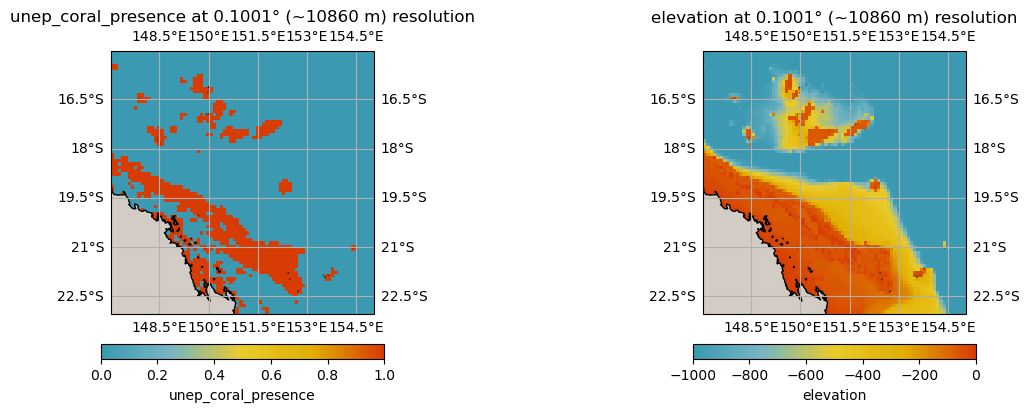

In [50]:
f, a = plt.subplots(ncols=2, figsize=(14,4), subplot_kw={"projection": ccrs.PlateCarree()})

spatial_plots.plot_spatial(
    unep_xa.sel(latitude=slice(min(larger_lat_sel),max(larger_lat_sel)), longitude=slice(min(larger_lon_sel),max(larger_lon_sel))),
    fax=(f,a[0]), orient_colorbar="horizontal"
    )
spatial_plots.plot_spatial(
    gebco_xa_resampled_to_other["elevation"].sel(latitude=slice(min(larger_lat_sel),max(larger_lat_sel)), longitude=slice(min(larger_lon_sel),max(larger_lon_sel))),
    val_lims=(-1000,0), fax=(f,a[1]), orient_colorbar="horizontal")

In [9]:
larger_lat_sel = [-23, -15]
larger_lon_sel = [147, 155] 

# spatial_plots.plot_spatial(gebco_xa_resampled["elevation"].sel(latitude=slice(min(larger_lat_sel),max(larger_lat_sel)), longitude=slice(min(larger_lon_sel),max(larger_lon_sel))))
# plt.scatter(
#     unep_xa.sel(latitude=slice(min(larger_lat_sel),max(larger_lat_sel)), longitude=slice(min(larger_lon_sel),max(larger_lon_sel))).values.flatten(),
#     gebco_xa_resampled_to_other["elevation"].sel(latitude=slice(min(larger_lat_sel),max(larger_lat_sel)), longitude=slice(min(larger_lon_sel),max(larger_lon_sel))).values.flatten())

In [132]:
resolutions = [
    1, 
0.5, 
0.25, 0.1, 
0.05, 0.01,
0.005,
]
depth_lims = [(-2000, 0), (-1500, 0),
(-1000, 0), (-500, 0), (-200, 0), (-100, 0), (-80, 0), (-60, 0), (-40, 0), (-20, 0)
]

vals = []
unep_val_sample = []
gebco_val_sample = []
num_points = 10000

for resolution in tqdm(resolutions, desc=f"iterating over {len(resolutions)} resolution(s)..."):
    # generate gt raster at correct resolution
    unep_raster = functions_creche.rasterize_geodf(
        unep_gdf, resolution_lat=resolution, resolution_lon=resolution
    )
    # generate gt xarray at correct resolution
    unep_xa = spatial_data.process_xa_d(functions_creche.raster_to_xarray(
        unep_raster,
        x_y_limits=functions_creche.lat_lon_vals_from_geo_df(unep_gdf)[:4],
        resolution_lat=resolution,
        resolution_lon=resolution,
        name="unep_coral_presence",
    )).sel(latitude=slice(min(lats), max(lats)), longitude=slice(min(lons), max(lons)))

    # scale gebco bathymetry to correct resolution
    gebco_xa_resampled = functions_creche.resample_to_other(gebco_xa, unep_xa).compute()
    
    if len(unep_xa.values.flatten()) < num_points:
        unep_val_sample.append(unep_xa.values.flatten())
        gebco_val_sample.append(gebco_xa_resampled["elevation"].values.flatten())
    else:
        unep_val_sample.append(unep_xa.values.flatten()[::int(len(unep_xa.values.flatten())/num_points)])
        gebco_val_sample.append(gebco_xa_resampled["elevation"].values.flatten()[::int(len(unep_xa.values.flatten())/num_points)])

    # get ratios of coral presence to bathymetry
    vals.append(functions_creche.investigate_depth_mask(
        comp_var_xa=unep_xa, mask_var_xa=gebco_xa_resampled, var_limits=depth_lims))
    

iterating over 7 resolution(s)...: 100%|██████████| 7/7 [07:10<00:00, 61.52s/it]


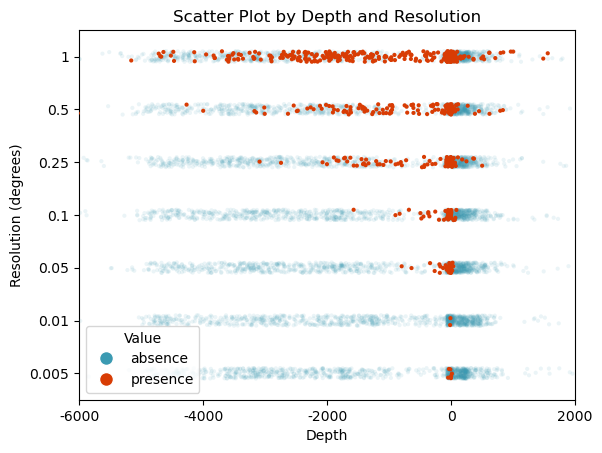

In [130]:
N = len(resolutions)

data = {"resolution": [], "depth": [], "value": []}

for i in range(N):
    data["resolution"].extend([str(resolutions[i])] * len(gebco_val_sample[i]))
    data["depth"].extend(gebco_val_sample[i])
    data["value"].extend(unep_val_sample[i])
    
df_cat = pd.DataFrame(data)


# Separate the data based on 'value' for plotting
df_value_0 = df_cat[df_cat['value'] == 0]
df_value_1 = df_cat[df_cat['value'] == 1]



value_colours = ("#3B9AB2", "#d83c04")
palette_1 = [value_colours[val] for val in df_value_0["value"].unique()]
palette_2 = [value_colours[val] for val in df_value_1["value"].unique()]

# Create a scatter plot with Seaborn's stripplot for value '0' first
ax = sns.stripplot(data=df_value_0, x="depth", y="resolution", hue="value", palette=palette_1, legend=False, s=3, alpha=0.1)

# Then plot value '1' on top with full opacity
sns.stripplot(data=df_value_1, x="depth", y="resolution", hue="value", palette=palette_2, legend=False, s=3, alpha=1.0, ax=ax)

        
plt.ylabel("Resolution (degrees)")
plt.xlabel("Depth")  # Empty x-axis label
plt.title("Scatter Plot by Depth and Resolution")

# # Manipulate x-axis ticks and labels to show only every 100th value
new_ticks = ax.get_xticks()[::1]
ax.set_xticks(new_ticks)
ax.set_xticklabels([f'{int(val)}' for val in new_ticks])

plt.xlim([-6000, 2000])
# palette = sns.color_palette("coolwarm", df_cat["value"].nunique())

unique_values = df_cat["value"].unique()

# # Show legend manually
# Create a legend with matching colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10, label=str(val)) for i, val in enumerate(["absence", "presence"])]
plt.legend(handles=legend_handles, title="Value", loc="lower left");


In [126]:
# f, ax1 = plt.subplots(figsize=(10, 10))
# ax2 = ax1.twinx()

# colours = spatial_plots.get_n_colors_from_hexes(len(resolutions))

# x_labels = [str(depth_lim) for depth_lim in depth_lims]

# for i, val_list in enumerate(vals):
#     val_sums, val_ratios = [val[0] for val in vals], [val[1] for val in vals]
#     for j, resolution in enumerate(resolutions[::-1]):
#         ax1.scatter(x_labels, val_sums[j]/max(val_sums[j]), label=f"resolution: {resolution}", c=colours[j], marker="o")
#         ax2.scatter(x_labels, val_ratios[j], label=f"resolution: {resolution}", c=colours[j], marker="x")
    
#     ax1.set_ylabel("total coral presence")
#     ax2.set_ylabel("coral presence-absence ratio")
#     ax1.set_xlabel("depth limits (m)")
#     plt.suptitle("class imbalance as function of depth limiting")


# # Create legends for markers (resolutions)
# legend_lines_1 = [
#     Line2D([0], [0], color=colours[j], marker="o", linestyle='None', label=f"resolution: {resolutions[j]}")
#     for j in range(len(resolutions))
# ]
# ax1.legend(handles=legend_lines_1, loc='upper left', title="# grid cells containing coral")

# legend_lines_2 = [
#     Line2D([0], [0], color=colours[j], marker="x", linestyle='None', label=f"resolution: {resolutions[j]}")
#     for j in range(len(resolutions))
# ]
# ax2.legend(handles=legend_lines_2, loc='upper right', title="coral presence-absence ratio")

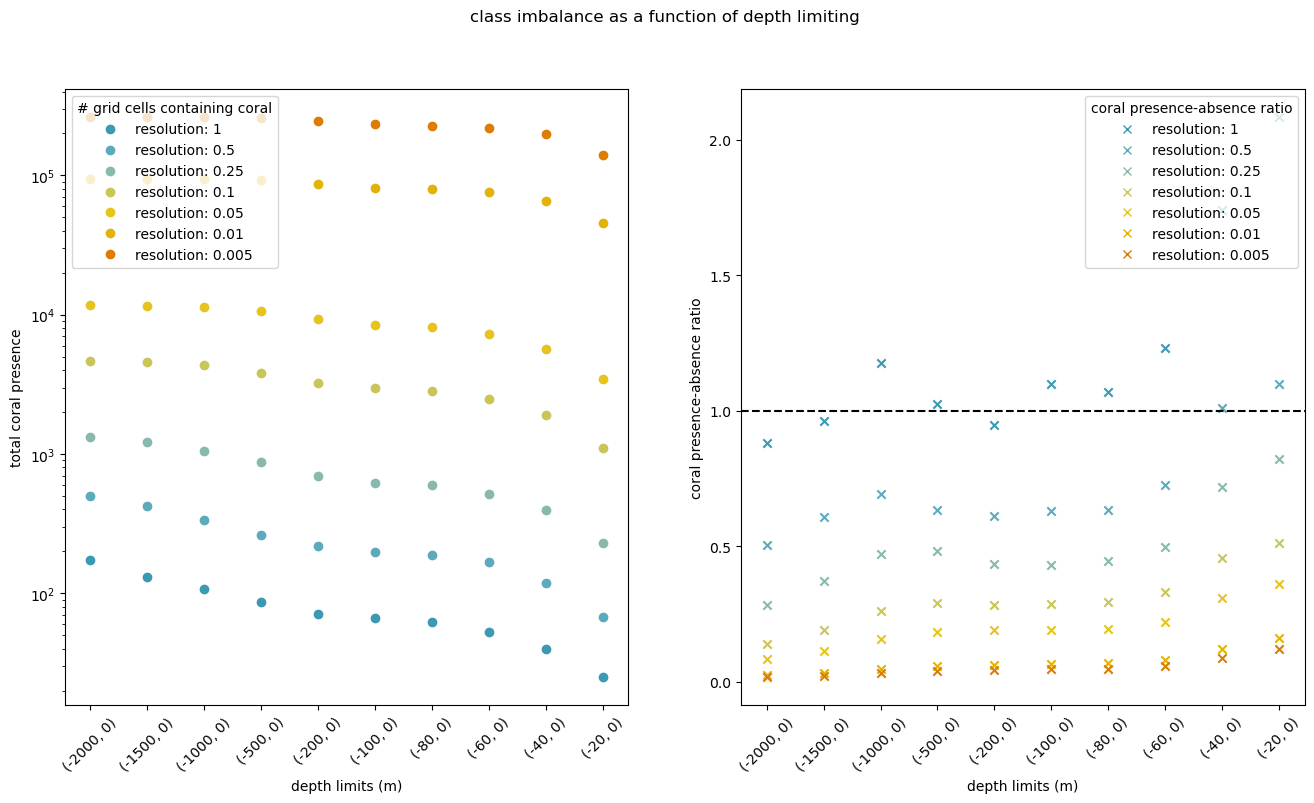

In [125]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming you have defined the variables vals, resolutions, depth_lims, and spatial_plots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))  # Creating side-by-side subplots

colours = spatial_plots.get_n_colors_from_hexes(len(resolutions))
x_labels = [str(depth_lim) for depth_lim in depth_lims]

for j, resolution in enumerate(resolutions[::-1]):
    # val_sums = [val[0] for val in vals]
    # val_ratios = [val[1] for val in vals]
    val_sums = vals[j][0]
    val_ratios = vals[j][1]
    # ax1.scatter(x_labels, val_sums / max(val_sums), label=f"resolution: {resolution}", c=colours[j], marker="o") # normalised
    ax1.scatter(x_labels, val_sums, label=f"resolution: {resolution}", c=colours[j], marker="o")
    ax2.scatter(x_labels, val_ratios, label=f"resolution: {resolution}", c=colours[j], marker="x")

ax1.set_ylabel("total coral presence")
ax2.set_ylabel("coral presence-absence ratio")
ax1.set_xlabel("depth limits (m)")
ax2.set_xlabel("depth limits (m)")
plt.suptitle("class imbalance as a function of depth limiting")

# Create legends for markers (resolutions)
legend_lines_1 = [
    Line2D([0], [0], color=colours[j], marker="o", linestyle='None', label=f"resolution: {resolutions[j]}")
    for j in range(len(resolutions))
]
ax1.legend(handles=legend_lines_1, loc='upper left', title="# grid cells containing coral")
ax1.set_yscale("log")

legend_lines_2 = [
    Line2D([0], [0], color=colours[j], marker="x", linestyle='None', label=f"resolution: {resolutions[j]}")
    for j in range(len(resolutions))
]
ax2.legend(handles=legend_lines_2, loc='upper right', title="coral presence-absence ratio")
ax2.axhline(1, c="k", ls="--")

ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)

plt.show()


# CDS CMIP

In [ ]:
thetao_concatted = xa.open_dataset("/home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/concatted_vars/thetao_lats_-40-0_lons_130-170.nc")

In [ ]:
from coralshift.dataloading import config

In [ ]:
concatted_dir = Path("/home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/concatted_vars")
var_nc_fs = list(Path(concatted_dir).glob("*.nc"))

vars = [str(fname.name).split("_")[0] for fname in var_nc_fs]
concatted_name = "_".join(vars) + ".nc"
concatted_name

'uo_so_vo_thetao_tos.nc'

In [ ]:
var_nc_fs

[PosixPath('/home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/concatted_vars/uo_lats_-40-0_lons_130-170.nc'),
 PosixPath('/home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/concatted_vars/so_lats_-40-0_lons_130-170.nc'),
 PosixPath('/home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/concatted_vars/vo_lats_-40-0_lons_130-170.nc'),
 PosixPath('/home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/concatted_vars/thetao_lats_-40-0_lons_130-170.nc'),
 PosixPath('/home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/concatted_vars/tos_lats_-40-0_lons_130-170.nc')]

In [ ]:
dss = [xa.open_dataset(fname) for fname in var_nc_fs]
merged = xa.merge(dss)
merged

<xarray.Dataset>
Dimensions:    (time: 780, bnds: 2, lev: 1, lat: 160, lon: 160)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lev        (lev) float64 5.0
  * lat        (lat) float64 -39.88 -39.62 -39.38 ... -0.625 -0.375 -0.125
  * lon        (lon) float64 130.1 130.4 130.6 130.9 ... 169.1 169.4 169.6 169.9
    latitude   (lat, lon) float32 -39.88 -39.88 -39.88 ... -0.125 -0.125 -0.125
    longitude  (lat, lon) float32 -229.9 -229.6 -229.4 ... -190.6 -190.4 -190.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 1950-01-01 00:00:00 ... 2015-01-01 00:00:00
    lev_bnds   (time, lev, bnds) float64 0.0 10.0 0.0 10.0 ... 0.0 10.0 0.0 10.0
    lat_bnds   (time, lat, bnds) float64 -40.0 -39.75 -39.75 ... -0.25 -0.25 0.0
    lon_bnds   (time, lon, bnds) float64 130.0 130.2 130.2 ... 169.8 169.8 170.0
    uo         (time, lev, lat, lon) float32 ...
    so         (time, lev, lat, lon) float32 ...
    vo         (time, lev, lat, lon) float32 ...
    thetao     (time, lev, lat, lon) float32 ...
    tos        (time, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     HighResMIP
    branch_method:                   Standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    comment:                         The model integration starts from the pi...
    ...                              ...
    tracking_id:                     hdl:21.14100/a9515288-7519-4213-9937-422...
    variable_id:                     uo
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by BCC is lice...
    cmor_version:                    3.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [7]:
merged = xa.open_dataset("data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/uo_so_vo_thetao_tos_buffered.nc")
ds = merged

In [3]:
dp = "data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/16_split_datasets"
ncs = list(Path(dp).glob("*.nc"))
# xa.open_mfdataset(nc_fps)["so"].isel(time=0).plot()
# len(list(nc_fps))

/home/rt582/rds/.conda/envs/pycoral/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]
/home/rt582/rds/.conda/envs/pycoral/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]
/home/rt582/rds/.conda/envs/pycoral/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]
/home/rt582/rds/.conda/envs/pycoral/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]
/home/rt582/rds/.conda/envs/pycoral/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generat

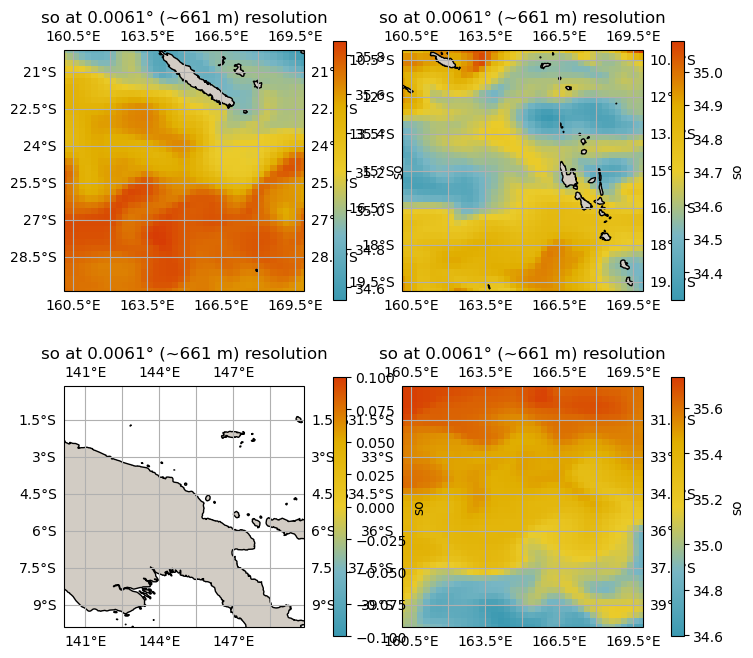

In [4]:
f,ax = plt.subplots(nrows = 2, ncols=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8,8))
axs = ax.ravel()
for i, fp in enumerate(axs):
    ds = spatial_data.process_xa_d(xa.open_dataset(list(Path(dp).glob("*.nc"))[i]))
    spatial_plots.plot_spatial(ds["so"].isel(time=0), fax=[f,axs[i]])

In [ ]:
dss = [xa.open_dataset(fp) for fp in nc_fps]

(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'so at 0.2500° (~27118 m) resolution'}, xlabel='Longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x14c2abf113c0>)

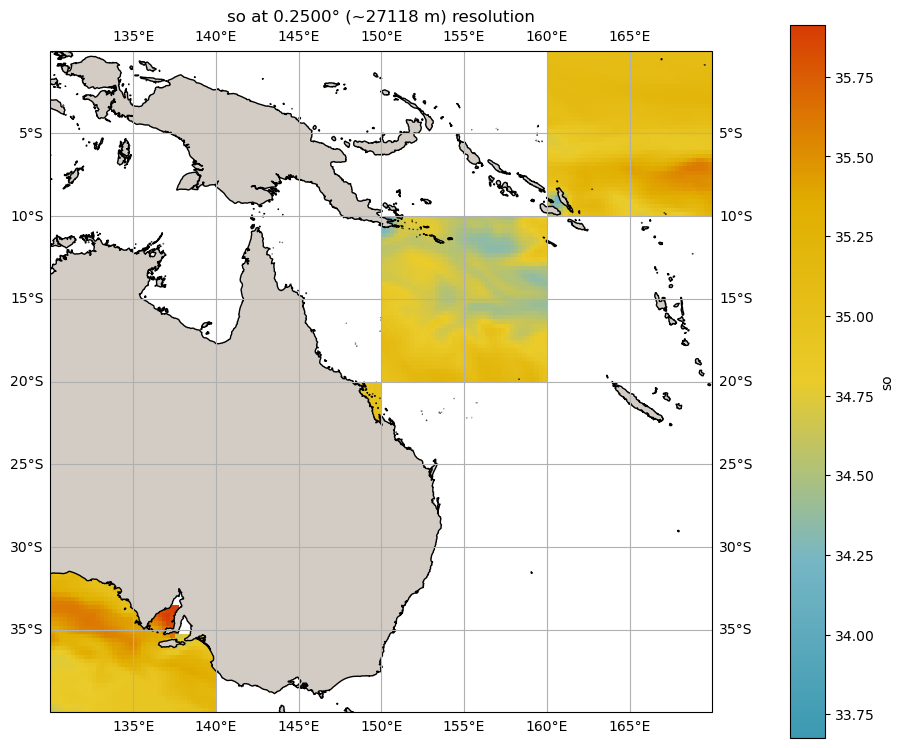

In [ ]:
spatial_plots.plot_spatial(xa.merge(dss)["so"].isel(time=0))

[<xarray.Dataset>
 Dimensions:         (time: 780, bnds: 2, latitude: 40, longitude: 40)
 Coordinates:
   * time            (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T...
     depth           float64 ...
   * latitude        (latitude) float64 -29.88 -29.62 -29.38 ... -20.38 -20.12
   * longitude       (longitude) float64 140.1 140.4 140.6 ... 149.4 149.6 149.9
     latitude_grid   (latitude, longitude) float32 ...
     longitude_grid  (latitude, longitude) float32 ...
 Dimensions without coordinates: bnds
 Data variables:
     time_bnds       (time, bnds) datetime64[ns] ...
     lev_bnds        (time, bnds) float64 ...
     lat_bnds        (time, latitude, bnds) float64 ...
     lon_bnds        (time, longitude, bnds) float64 ...
     uo              (time, latitude, longitude) float32 ...
     so              (time, latitude, longitude) float32 ...
     vo              (time, latitude, longitude) float32 ...
     thetao          (time, latitude, longitude) float32 ...
 

In [78]:
spatial_data.combine_ds_tiles(dss, resolution_d=0.25)

Pre-processing xarray objects:   0%|          | 0/3 [00:00<?, ?it/s]


MissingSpatialDimensionError: x dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'x' can address this. Data variable: time_bnds

In [65]:
list(nc_fps)

[]

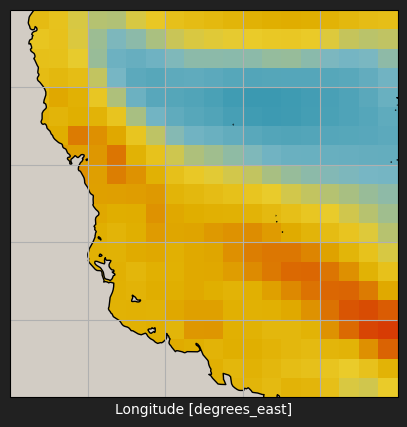

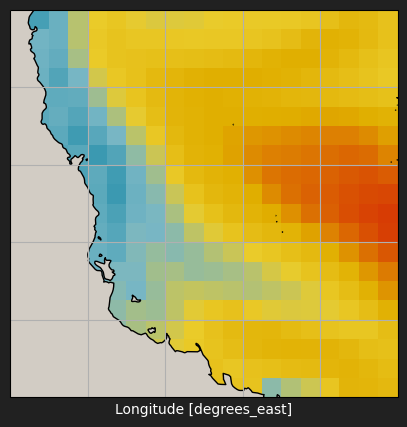

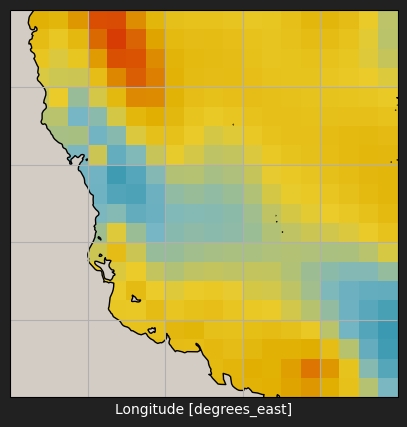

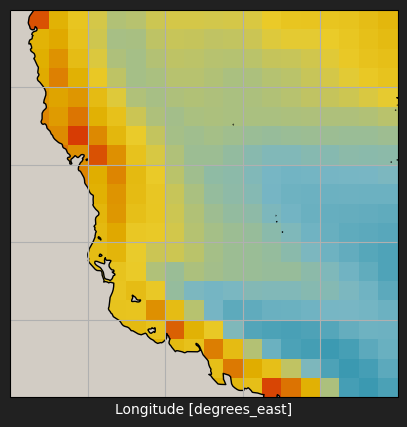

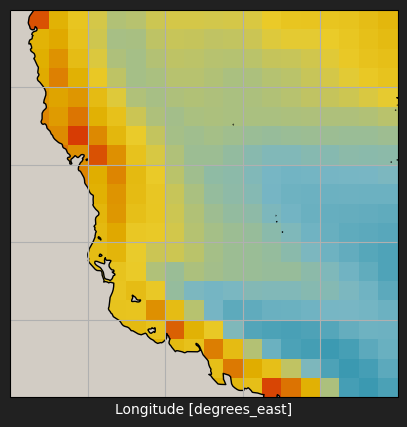

In [17]:
vars = ["uo", "so", "vo", "thetao", "tos"]
sub_lats = [-20,-15]
sub_lons = [145,150]

for i, var in enumerate(vars):
    f,ax = plt.subplots(figsize=(5, 25), subplot_kw={"projection": ccrs.PlateCarree()})
    ds = merged[var].isel(time=0)
    if "lev" in ds.coords:
        ds = ds.isel(lev=0)

    spatial_plots.plot_spatial(
        ds.sel(latitude=slice(min(sub_lats),max(sub_lats)), longitude=slice(min(sub_lons), max(sub_lons))), fax=(f,ax), 
    presentation=True
    )


# merged["so"].isel(time=0).plot()

In [ ]:
xa.open_mfdataset(var_nc_fs, combine="nested", concat_dim="time")

<xarray.Dataset>
Dimensions:    (time: 3900, bnds: 2, lev: 1, lat: 160, lon: 160)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lev        (lev) float64 5.0
  * lat        (lat) float64 -39.88 -39.62 -39.38 ... -0.625 -0.375 -0.125
  * lon        (lon) float64 130.1 130.4 130.6 130.9 ... 169.1 169.4 169.6 169.9
    latitude   (lat, lon) float32 dask.array<chunksize=(160, 160), meta=np.ndarray>
    longitude  (lat, lon) float32 dask.array<chunksize=(160, 160), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(780, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(780, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(780, 160, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(780, 160, 2), meta=np.ndarray>
    thetao     (time, lev, lat, lon) float32 dask.array<chunksize=(780, 1, 160, 160), meta=np.ndarray>
    so         (time, lev, lat, lon) float32 dask.array<chunksize=(3900, 1, 160, 160), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     HighResMIP
    branch_method:                   Standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    comment:                         The model integration starts from the pi...
    ...                              ...
    tracking_id:                     hdl:21.14100/d7c136d8-fd4b-49e5-b10a-e4e...
    variable_id:                     thetao
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by BCC is lice...
    cmor_version:                    3.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [ ]:
xa.open_dataset(var_nc_fs[0])

<xarray.Dataset>
Dimensions:    (time: 780, bnds: 2, lev: 1, lat: 160, lon: 160)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lev        (lev) float64 5.0
  * lat        (lat) float64 -39.88 -39.62 -39.38 ... -0.625 -0.375 -0.125
  * lon        (lon) float64 130.1 130.4 130.6 130.9 ... 169.1 169.4 169.6 169.9
    latitude   (lat, lon) float32 ...
    longitude  (lat, lon) float32 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lev_bnds   (time, lev, bnds) float64 ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    thetao     (time, lev, lat, lon) float32 ...
Attributes: (12/50)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     HighResMIP
    branch_method:                   Standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    comment:                         The model integration starts from the pi...
    ...                              ...
    tracking_id:                     hdl:21.14100/d7c136d8-fd4b-49e5-b10a-e4e...
    variable_id:                     thetao
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by BCC is lice...
    cmor_version:                    3.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [ ]:
xa.open_dataset(var_nc_fs[1])

<xarray.Dataset>
Dimensions:    (time: 780, bnds: 2, lev: 1, lat: 160, lon: 160)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lev        (lev) float64 5.0
  * lat        (lat) float64 -39.88 -39.62 -39.38 ... -0.625 -0.375 -0.125
  * lon        (lon) float64 130.1 130.4 130.6 130.9 ... 169.1 169.4 169.6 169.9
    latitude   (lat, lon) float32 ...
    longitude  (lat, lon) float32 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lev_bnds   (time, lev, bnds) float64 ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    thetao     (time, lev, lat, lon) float32 ...
Attributes: (12/50)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     HighResMIP
    branch_method:                   Standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    comment:                         The model integration starts from the pi...
    ...                              ...
    tracking_id:                     hdl:21.14100/d7c136d8-fd4b-49e5-b10a-e4e...
    variable_id:                     thetao
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by BCC is lice...
    cmor_version:                    3.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [ ]:
xa.open_mfdataset(var_nc_fs)

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [ ]:
if do_merge_by_vars:
    mergedvar_dir = os.path.join(download_folder, "merged_vars")
    assert os.path.exists(mergedvar_dir) and os.path.isdir(
        mergedvar_dir
    ), f"{mergedvar_dir} does not exist or is not a directory"
    var_nc_fs = list(Path(mergedvar_dir).glob("*.nc"))

    vars = [str(fname.name).split("_")[0] for fname in var_nc_fs]
    merged_name = "_".join(vars) + ".nc"
    merged_fp = os.path.join(download_folder, merged_name)

    if not os.path.exists(merged_fp):
        print(f"merging variable files... ", end="", flush=True)
        dss = [xr.open_dataset(fname) for fname in var_nc_fs]
        merged = xr.merge(dss)
        merged.to_netcdf(merged_fp)
    else:
        print(
            f"concatenated file already exists at {concatted_fp}",
            end="",
            flush=True,
        )

In [ ]:
conc_var_dir = "/home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/concatted_vars"

var_nc_fs = list(Path(conc_var_dir).glob("*.nc"))
var_nc_fs
vars = [str(fname.name).split("_")[0] for fname in var_nc_fs]

concatted_name = "_".join(vars) + ".nc"
concatted_name

'uo_so_vo_thetao_tos.nc'

In [ ]:
dss = [xa.open_dataset(fname) for fname in var_nc_fs]
merged = xa.merge(dss)

['uo', 'so', 'vo', 'thetao', 'tos']

In [ ]:
temp_dir = Path("/home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/so")
nc_fs = list(temp_dir.glob("*.nc"))

combined_ds = xa.open_mfdataset(nc_fs)

In [ ]:
combined_ds

<xarray.Dataset>
Dimensions:    (time: 780, bnds: 2, lev: 1, lat: 160, lon: 160)
Coordinates:
  * time       (time) object 1950-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lev        (lev) float64 5.0
  * lat        (lat) float64 -39.88 -39.62 -39.38 ... -0.625 -0.375 -0.125
  * lon        (lon) float64 130.1 130.4 130.6 130.9 ... 169.1 169.4 169.6 169.9
    latitude   (lat, lon) float32 dask.array<chunksize=(160, 160), meta=np.ndarray>
    longitude  (lat, lon) float32 dask.array<chunksize=(160, 160), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(12, 1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(12, 160, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(12, 160, 2), meta=np.ndarray>
    so         (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 160, 160), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     HighResMIP
    branch_method:                   Standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    comment:                         The model integration starts from the pi...
    ...                              ...
    tracking_id:                     hdl:21.14100/27624d6d-e5c9-4595-92ca-35b...
    variable_id:                     so
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by BCC is lice...
    cmor_version:                    3.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [ ]:
combined_newt = combined_ds.convert_calendar("gregorian")
combined_newt.time

<xarray.DataArray 'time' (time: 780)>
array(['1950-01-16T12:00:00.000000000', '1950-02-15T00:00:00.000000000',
       '1950-03-16T12:00:00.000000000', ..., '2014-10-16T12:00:00.000000000',
       '2014-11-16T00:00:00.000000000', '2014-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [ ]:
combined_ds = combined_ds.convert_calendar(calendar="gregorian", align_on="time", missing=-999)

ValueError: `date_range_like` was unable to generate a range as the source frequency was not inferable.

In [ ]:
combined_ds.time.values[0]

cftime.DatetimeNoLeap(1950, 1, 16, 12, 0, 0, 0, has_year_zero=True)

TypeError: float() argument must be a string or a real number, not 'cftime._cftime.DatetimeNoLeap'

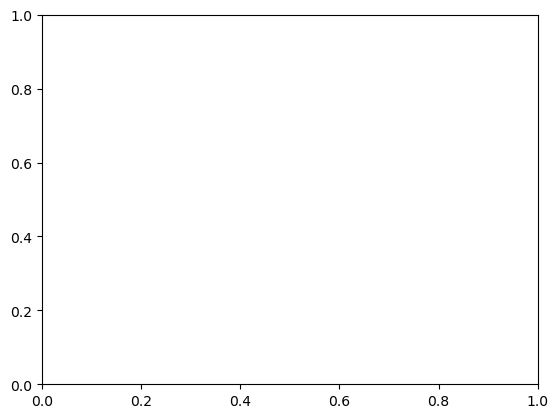

In [ ]:
import matplotlib.pyplot as plt


# WOA

In [ ]:
fp = "https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/1.00/woa18_decav_t01_01.nc"
fp_root = "https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/"

env_var_names = ["temperature", "salinity", "oxygen", "silicate", "nitrate", "phosphate"]
env_var_ids = ["t", "s", "o", "i", "n", "p"]
env_var_dict = dict(zip(env_var_names, env_var_ids))

decade_ids = ["decav", "5564", "6574", "7584", "8594", "95A4", "A5B7", "decav81B0"]
resolutions = [0.25, 1]


def resolution_to_string(resolution) -> str:
    if resolution == 0.25:
        return "04"
    elif resolution == 1:
        return "01"
    else:
        raise ValueError("Resolution must be floats of 0.25 or 1.00")


def generate_nc_name(env_var, env_var_dict, decade_id, resolution, month_i):
    name_root = "woa18"
    id = env_var_dict[env_var]

    end = id + utils.pad_number_with_zeros(month_i, 2) + "_" + resolution_to_string(resolution) + ".nc"

    return "_".join((name_root, decade_id, end))


def return_woa_url(env_var, decade_id, resolution, nc_name) -> str:
    fp_root = "https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/"

    url = "/".join((fp_root, env_var, decade_id, resolution_to_string(resolution), nc_name))
    return str(url)


def download_woa_data(env_var_names: list[str], env_var_dict: dict, decade_ids: list[str], resolutions: list[float]):
    for env_var in env_var_names:
        for decade_id in decade_ids:
            for resolution in resolutions:
                for month_i in range(1, 13):
                    nc_name = generate_nc_name(env_var, env_var_dict, decade_id, resolution, month_i)
                    url = return_woa_url(env_var, decade_id, resolution, nc_name)
                    print(url)

# TODO: implement seasonal and annual

def format_string_list(lst):
    if not lst:
        return ""
    return "var=" + "&var=".join(lst)


def generate_identifier(var):
    if var == "mld":
        return "A5B7"
    elif var == "temperature":
        return "5564"
    else:
        return "all"
    

def format_bounds(lat_bounds, lon_bounds):

    # Check latitude bounds
    assert all(-90 <= lat <= 90 for lat in lat_bounds), "Latitude values must be between -90 and 90"
    # Check longitude bounds
    assert all(-180 <= lon <= 180 for lon in lon_bounds), "Longitude values must be between -180 and 180"

    north, south = sorted(lat_bounds, reverse=True)
    east, west = sorted(lon_bounds)

    result = f"north={north}&west={west}&east={east}&south={south}"
    return result

# format_string_list(["asdf", "asdf", "asdf"])
format_bounds([-10, 10], [150, 180])


download_woa_data(env_var_names, env_var_dict, decade_ids, resolutions)

In [ ]:
woa_test_p = "/home/rt582/rds/hpc-work/coralshift/data/env_vars/1_woa18_5564_t16_01 (1).nc"
woa_test = spatial_data.process_xa_d(xa.open_dataset(woa_test_p, decode_times=False))

spatial_plots.plot_spatial(woa_test["t_an"].isel(time=0, depth=0))

# CMIP


In [ ]:
temp = spatial_data.process_xa_d(xa.open_dataset("/home/rt582/rds/hpc-work/coralshift/data/env_vars/evspsbl_Primday_HadGEM3-GC31-HH_control-1950_r1i1p1f1_gn_19500101-19500330.nc"))

# TODO: include this in process_xa_d
temp = temp.convert_calendar(calendar="gregorian", align_on="date", missing=-999)

from coralshift.plotting import spatial_plots
from coralshift.processing import spatial_data



spatial_plots.plot_spatial(temp["evspsbl"].isel(time=0))

## Fixing tri-polar projection

In [ ]:
# example file
ec = xa.open_dataset(Path(config.data_folder) / "env_vars/hfds_Omon_EC-Earth3P-HR_hist-1950_r1i1p2f1_gn_195001-195012.nc")
ec

In [ ]:
lons = ec["longitude"].values
lats = ec["latitude"].values
var = ec["hfds"].isel(time=0).values

In [ ]:
# plot of native
plt.pcolormesh(var, cmap="RdBu")

In [ ]:
# reprojected plot: is there a way to extract from this?
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

ax.set_global()

mesh = ax.pcolormesh(lons, lats, var, cmap='RdBu',
                     transform=ccrs.PlateCarree())

plt.colorbar(mesh, orientation='horizontal', shrink=0.75)

ax.gridlines()
ax.coastlines()

plt.show()

In [ ]:
# showing the discontinuity in longitude. TODO: plot alongisde latitudes
plt.pcolormesh(lons, cmap='RdBu')


In [ ]:
# attempt to fix discontinuity, from: https://gist.github.com/pelson/79cf31ef324774c97ae7
fixed_lons = lons.copy()
for i, start in enumerate(np.argmax(np.abs(np.diff(lons)) > 180, axis=1)):
    fixed_lons[i, start+1:] += 360

plt.figure(figsize=(8, 8))
plt.pcolormesh(fixed_lons, cmap='RdBu')
plt.colorbar()
plt.show()

In [ ]:
# another attempt to fix
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest, resample_gauss

lon2d, lat2d = np.meshgrid(np.arange(0,360.,0.25), np.arange(-90,90.,0.25))
origin_grid = SwathDefinition(lons=ec.longitude, lats=ec.latitude)
target_grid = SwathDefinition(lons=lon2d, lats=lat2d)

interpolated = resample_nearest(origin_grid, ec["hfds"].isel(time=0).values, target_grid, radius_of_influence=50000)
plt.imshow(interpolated)

In [ ]:
# another attempt
import pyinterp
import pyinterp.tests
import numpy as np

pyinterp.tests.load_grid2d()

np.meshgrid(np.arange(-180, 180, 1) + 1 / 3.0,
                        np.arange(-89, 89, 1) + 1 / 3.0,
                        indexing='ij')